# 11장. 시퀀스 모델을 위한 합성곱 신경망과 순환 신경망

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.jupyter.org/github/rickiepark/aiml4coders/blob/main/ch11/11-sequence-model.ipynb"><img src="https://jupyter.org/assets/share.png" width="61" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/aiml4coders/blob/main/ch11/11-sequence-model.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

## 시퀀스 데이터를 위한 합성곱

### 1D 합성곱 신경망 만들기

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2023-03-13 04:43:20.275807: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """임의로 정한 패턴이므로 바꿔도 좋습니다"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """기간마다 동일한 패턴을 반복합니다"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# 시계열을 만듭니다.
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# 잡음을 추가합니다.
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

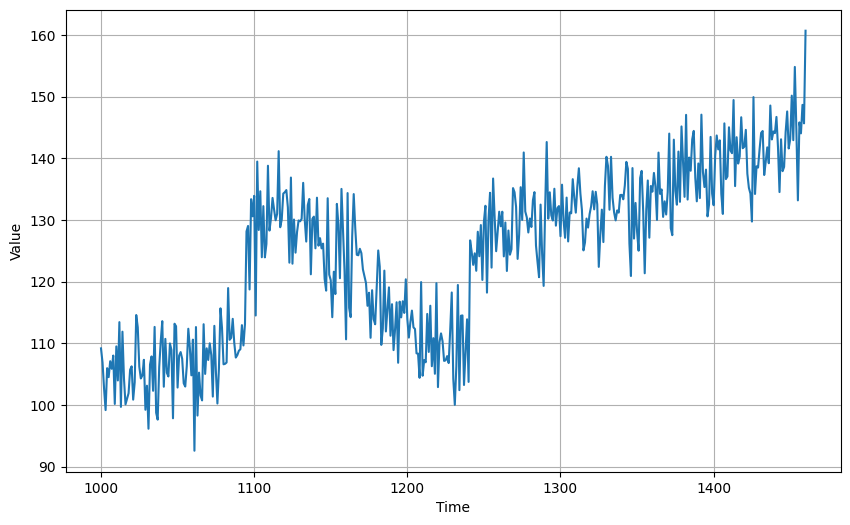

In [3]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [5]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=3,
                           strides=1, padding="causal",
                           activation="relu",
                           input_shape=[None, 1]),
    tf.keras.layers.Dense(28, activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.5)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100,  verbose=1)

2023-03-13 04:43:38.832629: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Epoch 1/100
31/31 [==============================] - 3s 14ms/step - loss: 2324.4463
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 114.9562
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 86.6698
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 74.5987
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 69.6165
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 67.4459
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 65.5755
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 65.3784
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 64.4725
Epoch 10/100
31/31 [==============================] - 0s 3ms/step 

In [6]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [7]:
forecast = model_forecast(model, series[..., np.newaxis], window_size)
results = forecast[split_time - window_size:-1, -1, 0]

46/46 [==============================] - 1s 8ms/step


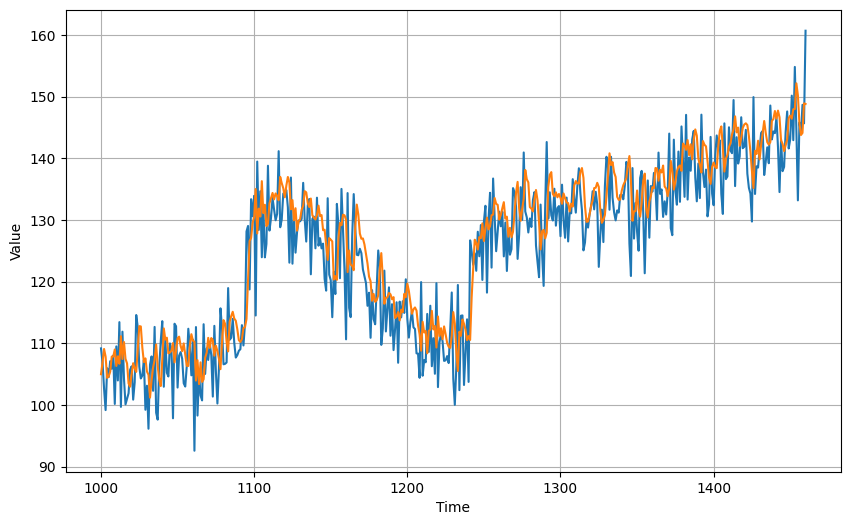

In [8]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [9]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.0228324

### Conv1D 하이퍼파라미터 튜닝

In [10]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 kB 6.5 MB/s eta 0:00:00
  Using cached tensorflow-2.11.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (588.3 MB)


In [11]:
from keras_tuner.tuners import RandomSearch

In [12]:
def build_model(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=hp.Int('units',min_value=128, max_value=256, step=64), 
                                     kernel_size=hp.Int('kernels', min_value=3, max_value=9, step=3),
                                     strides=hp.Int('strides', min_value=1, max_value=3, step=1),
                                     padding='causal', activation='relu', input_shape=[None, 1]))

    model.add(tf.keras.layers.Dense(28, input_shape=[window_size], activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='relu'))
    model.add(tf.keras.layers.Dense(1))

    sgd = tf.keras.optimizers.SGD(momentum=0.5, learning_rate=1e-5)
    model.compile(loss="mse", optimizer=sgd)
    return model

tuner = RandomSearch(build_model, objective='loss', max_trials=500, 
                     executions_per_trial=3, directory='my_dir', project_name='cnn-tune')

tuner.search_space_summary()

tuner.search(dataset, epochs=100, verbose=2)

Trial 27 Complete [00h 01m 40s]
loss: 62.50519688924154

Best loss So Far: 59.627271016438804
Total elapsed time: 00h 44m 24s
INFO:tensorflow:Oracle triggered exit


In [13]:
tuner.results_summary()

Results summary
Results in my_dir/cnn-tune
Showing 10 best trials
Trial summary
Hyperparameters:
units: 256
kernels: 9
strides: 1
Score: 59.627271016438804
Trial summary
Hyperparameters:
units: 128
kernels: 6
strides: 1
Score: 59.6495246887207
Trial summary
Hyperparameters:
units: 256
kernels: 6
strides: 1
Score: 59.660040537516274
Trial summary
Hyperparameters:
units: 192
kernels: 6
strides: 1
Score: 59.70044072469076
Trial summary
Hyperparameters:
units: 128
kernels: 9
strides: 1
Score: 59.85362879435221
Trial summary
Hyperparameters:
units: 192
kernels: 9
strides: 1
Score: 60.061319986979164
Trial summary
Hyperparameters:
units: 256
kernels: 3
strides: 1
Score: 61.413795471191406
Trial summary
Hyperparameters:
units: 192
kernels: 3
strides: 1
Score: 61.54514185587565
Trial summary
Hyperparameters:
units: 128
kernels: 6
strides: 2
Score: 61.55224736531576
Trial summary
Hyperparameters:
units: 128
kernels: 9
strides: 2
Score: 61.57798767089844


In [14]:
best_model = tuner.get_best_models(num_models=1)[0]

In [15]:
forecast = model_forecast(best_model, series[..., np.newaxis], window_size)
results = forecast[split_time - window_size:-1, -1, 0]

46/46 [==============================] - 0s 5ms/step


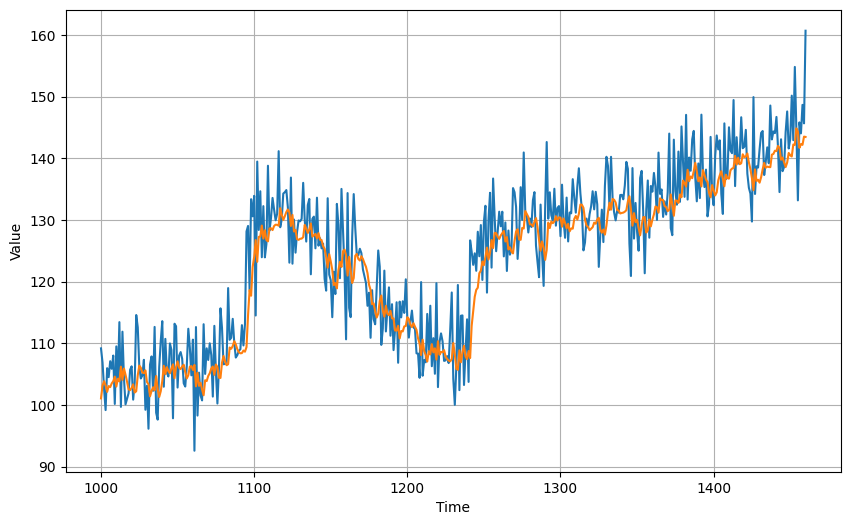

In [16]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [17]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.650504

## NASA 날씨 데이터 사용하기

### 파이썬으로 GISS 데이터 읽기

In [18]:
!wget https://storage.googleapis.com/learning-datasets/station.csv

--2023-03-13 05:29:21--  https://storage.googleapis.com/learning-datasets/station.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 172.253.117.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6979 (6.8K) [application/octet-stream]
Saving to: ‘station.csv’

station.csv         100%[===================>]   6.82K  --.-KB/s    in 0s      

2023-03-13 05:29:22 (50.5 MB/s) - ‘station.csv’ saved [6979/6979]



In [19]:
def get_station_data():
    data_file = "station.csv"
    f = open(data_file)
    data = f.read()
    f.close()
    lines = data.split('\n')
    header = lines[0].split(',')
    lines = lines[1:]
    temperatures=[]
    for line in lines:
        if line:
            linedata = line.split(',')
            linedata = linedata[1:13]
            for item in linedata:
                if item:
                    temperatures.append(float(item))
    series = np.asarray(temperatures)
    time = np.arange(len(temperatures), dtype="float32")
    return time, series

In [20]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [21]:
time, series = get_station_data()
mean = series.mean(axis=0)
series -= mean
std = series.std(axis=0)
series /= std

In [22]:
split_time = 792
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

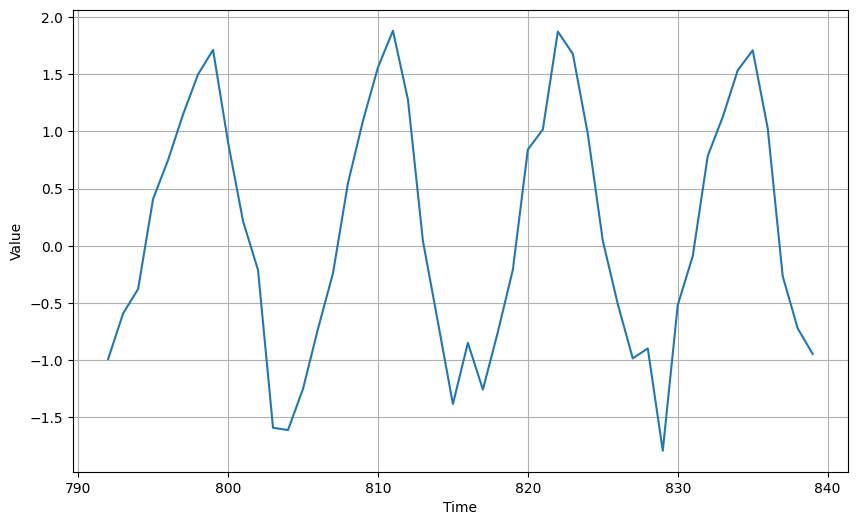

In [23]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [24]:
window_size = 24
batch_size = 12
shuffle_buffer_size = 48
dataset = windowed_dataset(x_train, window_size, 
                           batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, 
                                 batch_size, shuffle_buffer_size)

## RNN으로 시퀀스 모델링하기

In [25]:
model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(100, return_sequences=True, 
                              input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(100),
    tf.keras.layers.Dense(1)
])

In [26]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.5e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=100,  verbose=1,
                    validation_data=valid_dataset)

Epoch 1/100
64/64 [==============================] - 3s 16ms/step - loss: 0.5190 - mae: 0.9475 - val_loss: 0.5362 - val_mae: 0.9569
Epoch 2/100
64/64 [==============================] - 1s 11ms/step - loss: 0.4173 - mae: 0.8303 - val_loss: 0.4340 - val_mae: 0.8400
Epoch 3/100
64/64 [==============================] - 1s 11ms/step - loss: 0.3241 - mae: 0.7156 - val_loss: 0.3452 - val_mae: 0.7303
Epoch 4/100
64/64 [==============================] - 1s 11ms/step - loss: 0.2478 - mae: 0.6125 - val_loss: 0.2731 - val_mae: 0.6352
Epoch 5/100
64/64 [==============================] - 1s 11ms/step - loss: 0.1897 - mae: 0.5246 - val_loss: 0.2172 - val_mae: 0.5547
Epoch 6/100
64/64 [==============================] - 1s 12ms/step - loss: 0.1476 - mae: 0.4529 - val_loss: 0.1751 - val_mae: 0.4864
Epoch 7/100
64/64 [==============================] - 1s 12ms/step - loss: 0.1178 - mae: 0.3972 - val_loss: 0.1446 - val_mae: 0.4302
Epoch 8/100
64/64 [==============================] - 1s 11ms/step - loss: 0.

In [27]:
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1) 
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [28]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

2/2 [==============================] - 0s 24ms/step


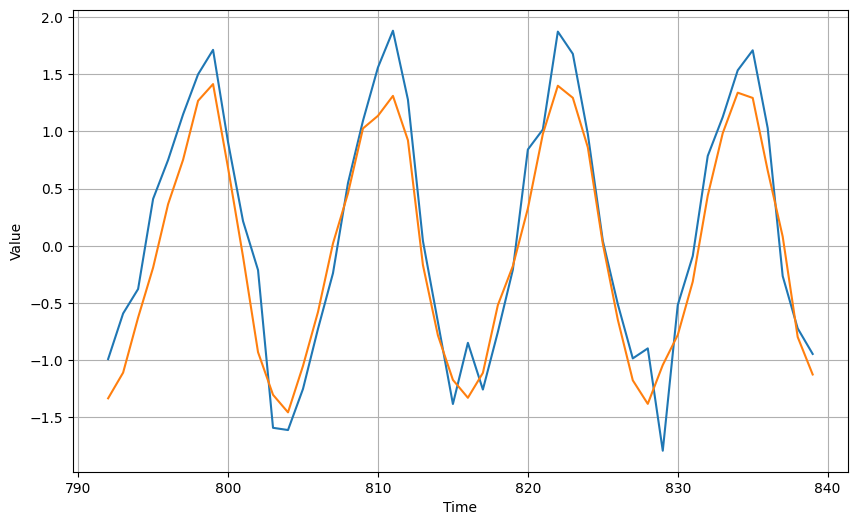

In [29]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

In [30]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

0.29024252

### 대용량 데이터셋 사용하기

In [31]:
!wget https://storage.googleapis.com/learning-datasets/tdaily_cet.dat.txt

--2023-03-13 05:31:22--  https://storage.googleapis.com/learning-datasets/tdaily_cet.dat.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.128, 74.125.197.128, 74.125.135.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1728976 (1.6M) [text/plain]
Saving to: ‘tdaily_cet.dat.txt’

tdaily_cet.dat.txt  100%[===================>]   1.65M  --.-KB/s    in 0.01s   

2023-03-13 05:31:23 (114 MB/s) - ‘tdaily_cet.dat.txt’ saved [1728976/1728976]



In [32]:
def get_tdaily_data():
    data_file = "tdaily_cet.dat.txt"
    f = open(data_file)
    data = f.read()
    f.close()
    lines = data.split('\n')
    temperatures=[]
    for line in lines:
        if line:
            linedata = line.split(' ')
            temperatures.append(float(linedata[1]))

    series = np.asarray(temperatures)
    time = np.arange(len(temperatures), dtype="float32")
    return time, series

In [33]:
time, series = get_tdaily_data()
mean = series.mean(axis=0)
series -= mean
std = series.std(axis=0)
series /= std

split_time = 80000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [34]:
window_size = 60
batch_size = 120
shuffle_buffer_size = 240

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(100, input_shape=[None, 1], return_sequences=True),
    tf.keras.layers.SimpleRNN(100), 
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=100, verbose=1, validation_data=valid_dataset)

Epoch 1/100
667/667 [==============================] - 64s 94ms/step - loss: 0.1091 - mae: 0.3632 - val_loss: 0.0741 - val_mae: 0.3035
Epoch 2/100
667/667 [==============================] - 62s 93ms/step - loss: 0.0762 - mae: 0.3076 - val_loss: 0.0658 - val_mae: 0.2862
Epoch 3/100
667/667 [==============================] - 62s 93ms/step - loss: 0.0701 - mae: 0.2947 - val_loss: 0.0613 - val_mae: 0.2766
Epoch 4/100
667/667 [==============================] - 60s 89ms/step - loss: 0.0664 - mae: 0.2867 - val_loss: 0.0584 - val_mae: 0.2701
Epoch 5/100
667/667 [==============================] - 66s 99ms/step - loss: 0.0640 - mae: 0.2811 - val_loss: 0.0563 - val_mae: 0.2656
Epoch 6/100
667/667 [==============================] - 65s 98ms/step - loss: 0.0622 - mae: 0.2769 - val_loss: 0.0548 - val_mae: 0.2621
Epoch 7/100
667/667 [==============================] - 71s 106ms/step - loss: 0.0609 - mae: 0.2738 - val_loss: 0.0536 - val_mae: 0.2594
Epoch 8/100
667/667 [==============================] -

In [35]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

334/334 [==============================] - 4s 13ms/step


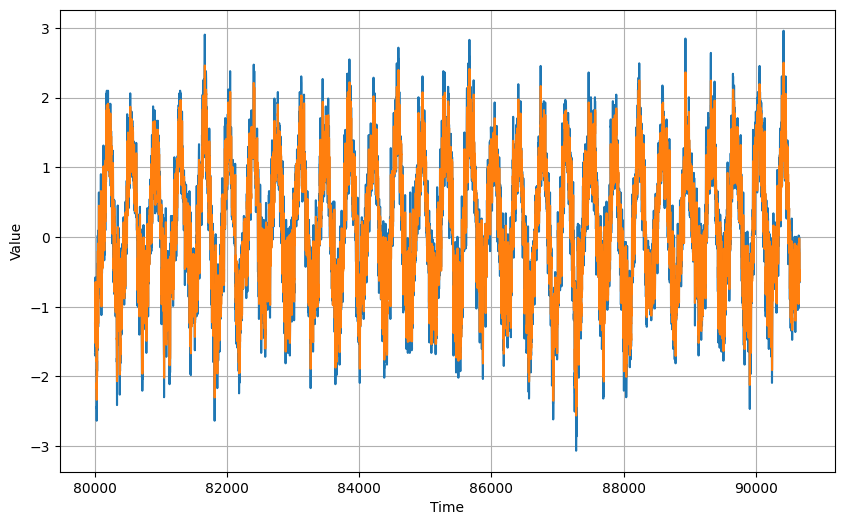

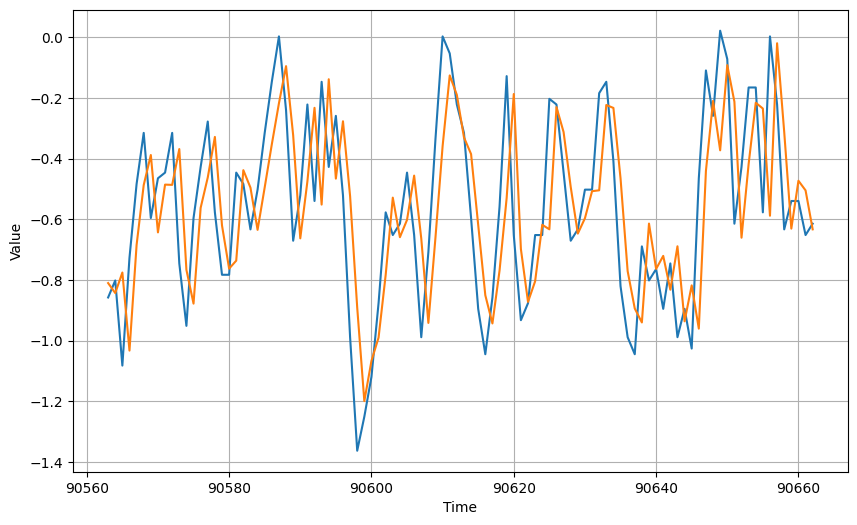

In [36]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

plt.figure(figsize=(10,6))
plot_series(time_valid[-100:], x_valid[-100:])
plot_series(time_valid[-100:], forecast[-100:])
plt.show()

In [37]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

0.24222177

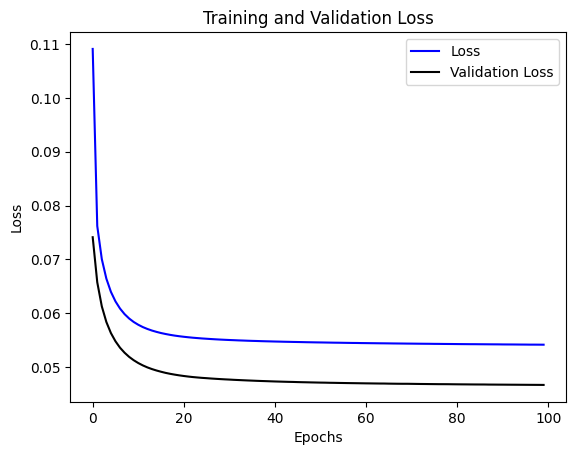

In [38]:
loss = history.history['loss']
val_mae = history.history['val_mae']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b')
plt.plot(epochs, val_loss, 'k')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.show()

## Dropout 사용하기

In [39]:
time, series = get_station_data()
mean = series.mean(axis=0)
series -= mean
std = series.std(axis=0)
series /= std

In [40]:
split_time = 792
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [41]:
window_size = 24
batch_size = 12
shuffle_buffer_size = 48
dataset = windowed_dataset(x_train, window_size, 
                           batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, 
                                 batch_size, shuffle_buffer_size)

In [42]:
model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(100, input_shape=[None, 1], return_sequences=True, 
                        dropout=0.1, recurrent_dropout=0.1),
    tf.keras.layers.GRU(100, dropout=0.1, recurrent_dropout=0.1),
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=500, verbose=1, validation_data=valid_dataset)

Epoch 1/500
64/64 [==============================] - 13s 136ms/step - loss: 0.4484 - mae: 0.8583 - val_loss: 0.4998 - val_mae: 0.9211
Epoch 2/500
64/64 [==============================] - 8s 123ms/step - loss: 0.4463 - mae: 0.8562 - val_loss: 0.4981 - val_mae: 0.9187
Epoch 3/500
64/64 [==============================] - 6s 96ms/step - loss: 0.4450 - mae: 0.8542 - val_loss: 0.4964 - val_mae: 0.9164
Epoch 4/500
64/64 [==============================] - 3s 54ms/step - loss: 0.4436 - mae: 0.8530 - val_loss: 0.4948 - val_mae: 0.9141
Epoch 5/500
64/64 [==============================] - 4s 55ms/step - loss: 0.4423 - mae: 0.8510 - val_loss: 0.4932 - val_mae: 0.9117
Epoch 6/500
64/64 [==============================] - 4s 55ms/step - loss: 0.4402 - mae: 0.8487 - val_loss: 0.4915 - val_mae: 0.9093
Epoch 7/500
64/64 [==============================] - 4s 56ms/step - loss: 0.4388 - mae: 0.8469 - val_loss: 0.4899 - val_mae: 0.9070
Epoch 8/500
64/64 [==============================] - 4s 55ms/step - loss:

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [43]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

2/2 [==============================] - 1s 41ms/step


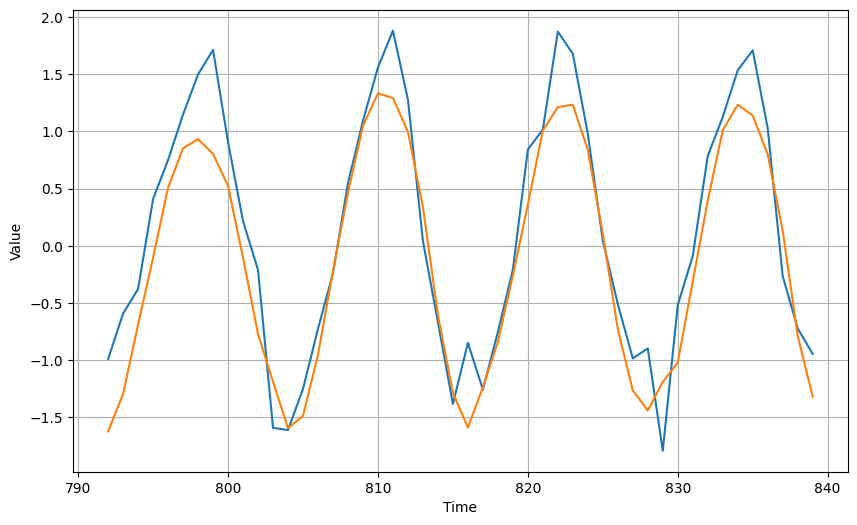

In [44]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

In [45]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

0.32309458

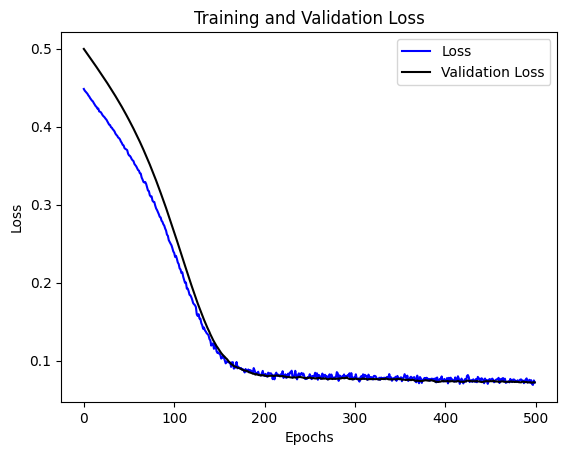

In [46]:
loss = history.history['loss']
val_mae = history.history['val_mae']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b')
plt.plot(epochs, val_loss, 'k')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.show()

## 양방향 RNN 사용하기

In [47]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(100, input_shape=[None, 1],return_sequences=True, 
                            dropout=0.1, recurrent_dropout=0.1)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(100, dropout=0.1, recurrent_dropout=0.1)),
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=500, verbose=1, validation_data=valid_dataset)

Epoch 1/500
64/64 [==============================] - 28s 226ms/step - loss: 0.4349 - mae: 0.8429 - val_loss: 0.4787 - val_mae: 0.9002
Epoch 2/500
64/64 [==============================] - 8s 130ms/step - loss: 0.4267 - mae: 0.8334 - val_loss: 0.4695 - val_mae: 0.8898
Epoch 3/500
64/64 [==============================] - 8s 128ms/step - loss: 0.4187 - mae: 0.8239 - val_loss: 0.4604 - val_mae: 0.8795
Epoch 4/500
64/64 [==============================] - 8s 129ms/step - loss: 0.4100 - mae: 0.8134 - val_loss: 0.4514 - val_mae: 0.8690
Epoch 5/500
64/64 [==============================] - 17s 268ms/step - loss: 0.4021 - mae: 0.8045 - val_loss: 0.4424 - val_mae: 0.8587
Epoch 6/500
64/64 [==============================] - 9s 132ms/step - loss: 0.3957 - mae: 0.7964 - val_loss: 0.4337 - val_mae: 0.8486
Epoch 7/500
64/64 [==============================] - 8s 128ms/step - loss: 0.3877 - mae: 0.7866 - val_loss: 0.4250 - val_mae: 0.8385
Epoch 8/500
64/64 [==============================] - 8s 126ms/step 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 227/500
64/64 [==============================] - 8s 126ms/step - loss: 0.0538 - mae: 0.2611 - val_loss: 0.0468 - val_mae: 0.2429
Epoch 228/500
64/64 [==============================] - 8s 129ms/step - loss: 0.0562 - mae: 0.2640 - val_loss: 0.0468 - val_mae: 0.2430
Epoch 229/500
64/64 [==============================] - 11s 178ms/step - loss: 0.0570 - mae: 0.2672 - val_loss: 0.0468 - val_mae: 0.2431
Epoch 230/500
64/64 [==============================] - 9s 132ms/step - loss: 0.0593 - mae: 0.2728 - val_loss: 0.0468 - val_mae: 0.2431
Epoch 231/500
64/64 [==============================] - 8s 131ms/step - loss: 0.0586 - mae: 0.2677 - val_loss: 0.0468 - val_mae: 0.2431
Epoch 232/500
64/64 [==============================] - 8s 126ms/step - loss: 0.0557 - mae: 0.2640 - val_loss: 0.0468 - val_mae: 0.2431
Epoch 233/500
64/64 [==============================] - 8s 127ms/step - loss: 0.0553 - mae: 0.2606 - val_loss: 0.0468 - val_mae: 0.2431
Epoch 234/500
64/64 [==============================] -

In [48]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

2/2 [==============================] - 1s 35ms/step


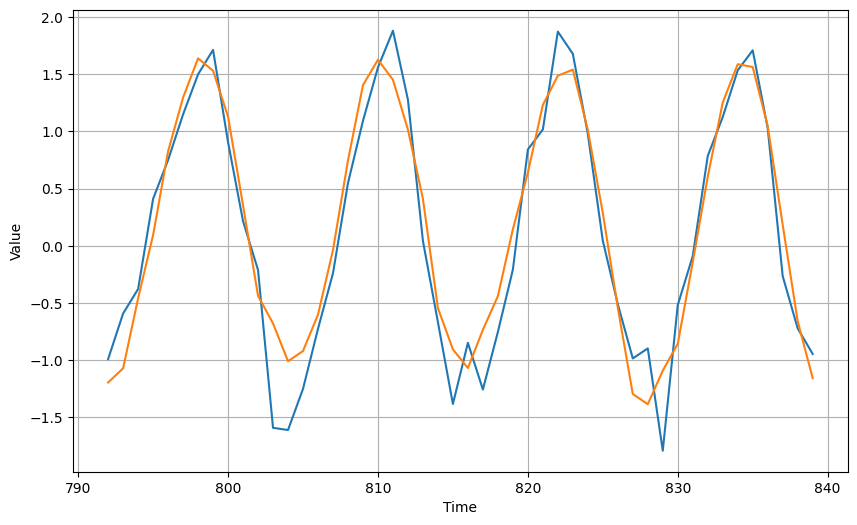

In [49]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

In [50]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

0.2585878

윈도우 크기 늘려 보기

In [51]:
window_size = 40
batch_size = 12
shuffle_buffer_size = 48
dataset = windowed_dataset(x_train, window_size, 
                           batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, 
                                 batch_size, shuffle_buffer_size)

In [52]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(100, input_shape=[None, 1],return_sequences=True, 
                            dropout=0.1, recurrent_dropout=0.1)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(100, dropout=0.1, recurrent_dropout=0.1)),
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=500, verbose=1, validation_data=valid_dataset)

Epoch 1/500
63/63 [==============================] - 37s 454ms/step - loss: 0.4698 - mae: 0.8822 - val_loss: 0.5764 - val_mae: 1.0375
Epoch 2/500
63/63 [==============================] - 13s 209ms/step - loss: 0.4645 - mae: 0.8765 - val_loss: 0.5733 - val_mae: 1.0351
Epoch 3/500
63/63 [==============================] - 25s 398ms/step - loss: 0.4614 - mae: 0.8722 - val_loss: 0.5702 - val_mae: 1.0327
Epoch 4/500
63/63 [==============================] - 14s 222ms/step - loss: 0.4571 - mae: 0.8677 - val_loss: 0.5669 - val_mae: 1.0302
Epoch 5/500
63/63 [==============================] - 13s 213ms/step - loss: 0.4542 - mae: 0.8646 - val_loss: 0.5633 - val_mae: 1.0275
Epoch 6/500
63/63 [==============================] - 25s 401ms/step - loss: 0.4502 - mae: 0.8592 - val_loss: 0.5602 - val_mae: 1.0250
Epoch 7/500
63/63 [==============================] - 13s 214ms/step - loss: 0.4468 - mae: 0.8554 - val_loss: 0.5569 - val_mae: 1.0224
Epoch 8/500
63/63 [==============================] - 24s 378ms

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



63/63 [==============================] - 14s 221ms/step - loss: 0.1810 - mae: 0.5086 - val_loss: 0.2131 - val_mae: 0.6257
Epoch 96/500
63/63 [==============================] - 14s 219ms/step - loss: 0.1708 - mae: 0.4928 - val_loss: 0.2094 - val_mae: 0.6197
Epoch 97/500
63/63 [==============================] - 20s 308ms/step - loss: 0.1722 - mae: 0.4925 - val_loss: 0.2057 - val_mae: 0.6138
Epoch 98/500
63/63 [==============================] - 14s 216ms/step - loss: 0.1665 - mae: 0.4856 - val_loss: 0.2019 - val_mae: 0.6077
Epoch 99/500
63/63 [==============================] - 17s 267ms/step - loss: 0.1663 - mae: 0.4830 - val_loss: 0.1982 - val_mae: 0.6016
Epoch 100/500
63/63 [==============================] - 24s 386ms/step - loss: 0.1639 - mae: 0.4821 - val_loss: 0.1943 - val_mae: 0.5952
Epoch 101/500
63/63 [==============================] - 14s 219ms/step - loss: 0.1566 - mae: 0.4679 - val_loss: 0.1906 - val_mae: 0.5890
Epoch 102/500
63/63 [==============================] - 20s 321ms/s

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



63/63 [==============================] - 14s 216ms/step - loss: 0.0768 - mae: 0.3163 - val_loss: 0.0643 - val_mae: 0.3050
Epoch 161/500
63/63 [==============================] - 18s 290ms/step - loss: 0.0734 - mae: 0.3037 - val_loss: 0.0636 - val_mae: 0.3035
Epoch 162/500
63/63 [==============================] - 22s 344ms/step - loss: 0.0744 - mae: 0.3093 - val_loss: 0.0630 - val_mae: 0.3018
Epoch 163/500
63/63 [==============================] - 17s 272ms/step - loss: 0.0735 - mae: 0.3082 - val_loss: 0.0622 - val_mae: 0.2996
Epoch 164/500
63/63 [==============================] - 20s 306ms/step - loss: 0.0744 - mae: 0.3063 - val_loss: 0.0615 - val_mae: 0.2976
Epoch 165/500
63/63 [==============================] - 14s 217ms/step - loss: 0.0693 - mae: 0.2982 - val_loss: 0.0607 - val_mae: 0.2953
Epoch 166/500
63/63 [==============================] - 14s 217ms/step - loss: 0.0772 - mae: 0.3183 - val_loss: 0.0599 - val_mae: 0.2924
Epoch 167/500
63/63 [==============================] - 22s 338

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



63/63 [==============================] - 25s 398ms/step - loss: 0.0643 - mae: 0.2875 - val_loss: 0.0479 - val_mae: 0.2465
Epoch 203/500
63/63 [==============================] - 16s 245ms/step - loss: 0.0624 - mae: 0.2746 - val_loss: 0.0478 - val_mae: 0.2455
Epoch 204/500
63/63 [==============================] - 14s 217ms/step - loss: 0.0615 - mae: 0.2837 - val_loss: 0.0476 - val_mae: 0.2449
Epoch 205/500
63/63 [==============================] - 27s 429ms/step - loss: 0.0634 - mae: 0.2829 - val_loss: 0.0475 - val_mae: 0.2438
Epoch 206/500
63/63 [==============================] - 13s 211ms/step - loss: 0.0621 - mae: 0.2821 - val_loss: 0.0474 - val_mae: 0.2431
Epoch 207/500
63/63 [==============================] - 27s 420ms/step - loss: 0.0645 - mae: 0.2822 - val_loss: 0.0474 - val_mae: 0.2433
Epoch 208/500
63/63 [==============================] - 14s 215ms/step - loss: 0.0635 - mae: 0.2826 - val_loss: 0.0472 - val_mae: 0.2423
Epoch 209/500
63/63 [==============================] - 25s 401

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



63/63 [==============================] - 14s 221ms/step - loss: 0.0626 - mae: 0.2822 - val_loss: 0.0457 - val_mae: 0.2370
Epoch 239/500
63/63 [==============================] - 15s 242ms/step - loss: 0.0632 - mae: 0.2847 - val_loss: 0.0457 - val_mae: 0.2367
Epoch 240/500
63/63 [==============================] - 20s 310ms/step - loss: 0.0626 - mae: 0.2813 - val_loss: 0.0457 - val_mae: 0.2369
Epoch 241/500
63/63 [==============================] - 14s 219ms/step - loss: 0.0606 - mae: 0.2768 - val_loss: 0.0457 - val_mae: 0.2367
Epoch 242/500
63/63 [==============================] - 16s 261ms/step - loss: 0.0615 - mae: 0.2759 - val_loss: 0.0457 - val_mae: 0.2368
Epoch 243/500
63/63 [==============================] - 20s 307ms/step - loss: 0.0667 - mae: 0.2901 - val_loss: 0.0457 - val_mae: 0.2366
Epoch 244/500
63/63 [==============================] - 14s 218ms/step - loss: 0.0593 - mae: 0.2738 - val_loss: 0.0455 - val_mae: 0.2361
Epoch 245/500
63/63 [==============================] - 18s 286

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



63/63 [==============================] - 23s 356ms/step - loss: 0.0608 - mae: 0.2726 - val_loss: 0.0456 - val_mae: 0.2351
Epoch 303/500
63/63 [==============================] - 14s 214ms/step - loss: 0.0613 - mae: 0.2830 - val_loss: 0.0457 - val_mae: 0.2352
Epoch 304/500
63/63 [==============================] - 14s 217ms/step - loss: 0.0621 - mae: 0.2790 - val_loss: 0.0457 - val_mae: 0.2352
Epoch 305/500
63/63 [==============================] - 27s 423ms/step - loss: 0.0607 - mae: 0.2799 - val_loss: 0.0457 - val_mae: 0.2353
Epoch 306/500
63/63 [==============================] - 14s 218ms/step - loss: 0.0626 - mae: 0.2803 - val_loss: 0.0456 - val_mae: 0.2348
Epoch 307/500
63/63 [==============================] - 22s 354ms/step - loss: 0.0628 - mae: 0.2805 - val_loss: 0.0456 - val_mae: 0.2351
Epoch 308/500
63/63 [==============================] - 14s 216ms/step - loss: 0.0601 - mae: 0.2749 - val_loss: 0.0456 - val_mae: 0.2350
Epoch 309/500
63/63 [==============================] - 16s 262

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 346/500
63/63 [==============================] - 20s 314ms/step - loss: 0.0600 - mae: 0.2767 - val_loss: 0.0457 - val_mae: 0.2345
Epoch 347/500
63/63 [==============================] - 14s 219ms/step - loss: 0.0629 - mae: 0.2836 - val_loss: 0.0456 - val_mae: 0.2344
Epoch 348/500
63/63 [==============================] - 14s 216ms/step - loss: 0.0585 - mae: 0.2731 - val_loss: 0.0459 - val_mae: 0.2351
Epoch 349/500
63/63 [==============================] - 23s 373ms/step - loss: 0.0631 - mae: 0.2862 - val_loss: 0.0458 - val_mae: 0.2349
Epoch 350/500
63/63 [==============================] - 14s 219ms/step - loss: 0.0641 - mae: 0.2852 - val_loss: 0.0460 - val_mae: 0.2354
Epoch 351/500
63/63 [==============================] - 18s 289ms/step - loss: 0.0617 - mae: 0.2797 - val_loss: 0.0460 - val_mae: 0.2354
Epoch 352/500
63/63 [==============================] - 23s 365ms/step - loss: 0.0578 - mae: 0.2714 - val_loss: 0.0460 - val_mae: 0.2354
Epoch 353/500
63/63 [===========================

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



63/63 [==============================] - 15s 245ms/step - loss: 0.0589 - mae: 0.2748 - val_loss: 0.0460 - val_mae: 0.2352
Epoch 374/500
63/63 [==============================] - 20s 318ms/step - loss: 0.0597 - mae: 0.2721 - val_loss: 0.0459 - val_mae: 0.2349
Epoch 375/500
63/63 [==============================] - 14s 217ms/step - loss: 0.0591 - mae: 0.2759 - val_loss: 0.0460 - val_mae: 0.2353
Epoch 376/500
63/63 [==============================] - 16s 258ms/step - loss: 0.0589 - mae: 0.2766 - val_loss: 0.0461 - val_mae: 0.2355
Epoch 377/500
63/63 [==============================] - 20s 318ms/step - loss: 0.0589 - mae: 0.2744 - val_loss: 0.0461 - val_mae: 0.2356
Epoch 378/500
63/63 [==============================] - 14s 221ms/step - loss: 0.0626 - mae: 0.2819 - val_loss: 0.0462 - val_mae: 0.2358
Epoch 379/500
63/63 [==============================] - 14s 218ms/step - loss: 0.0596 - mae: 0.2722 - val_loss: 0.0461 - val_mae: 0.2355
Epoch 380/500
63/63 [==============================] - 25s 405

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



63/63 [==============================] - 14s 214ms/step - loss: 0.0586 - mae: 0.2698 - val_loss: 0.0465 - val_mae: 0.2363
Epoch 438/500
63/63 [==============================] - 23s 364ms/step - loss: 0.0599 - mae: 0.2772 - val_loss: 0.0463 - val_mae: 0.2358
Epoch 439/500
63/63 [==============================] - 14s 217ms/step - loss: 0.0617 - mae: 0.2831 - val_loss: 0.0463 - val_mae: 0.2359
Epoch 440/500
63/63 [==============================] - 26s 411ms/step - loss: 0.0612 - mae: 0.2781 - val_loss: 0.0465 - val_mae: 0.2363
Epoch 441/500
63/63 [==============================] - 14s 224ms/step - loss: 0.0587 - mae: 0.2742 - val_loss: 0.0464 - val_mae: 0.2361
Epoch 442/500
63/63 [==============================] - 20s 315ms/step - loss: 0.0570 - mae: 0.2658 - val_loss: 0.0464 - val_mae: 0.2361
Epoch 443/500
63/63 [==============================] - 22s 344ms/step - loss: 0.0567 - mae: 0.2706 - val_loss: 0.0462 - val_mae: 0.2355
Epoch 444/500
63/63 [==============================] - 20s 312

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



63/63 [==============================] - 13s 213ms/step - loss: 0.0567 - mae: 0.2707 - val_loss: 0.0466 - val_mae: 0.2359
Epoch 488/500
63/63 [==============================] - 14s 227ms/step - loss: 0.0587 - mae: 0.2787 - val_loss: 0.0465 - val_mae: 0.2359
Epoch 489/500
63/63 [==============================] - 19s 304ms/step - loss: 0.0583 - mae: 0.2698 - val_loss: 0.0465 - val_mae: 0.2358
Epoch 490/500
63/63 [==============================] - 14s 215ms/step - loss: 0.0574 - mae: 0.2686 - val_loss: 0.0464 - val_mae: 0.2354
Epoch 491/500
63/63 [==============================] - 16s 252ms/step - loss: 0.0583 - mae: 0.2740 - val_loss: 0.0464 - val_mae: 0.2355
Epoch 492/500
63/63 [==============================] - 25s 389ms/step - loss: 0.0602 - mae: 0.2753 - val_loss: 0.0466 - val_mae: 0.2360
Epoch 493/500
63/63 [==============================] - 13s 210ms/step - loss: 0.0625 - mae: 0.2799 - val_loss: 0.0466 - val_mae: 0.2361
Epoch 494/500
63/63 [==============================] - 17s 264

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [53]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

2/2 [==============================] - 1s 45ms/step


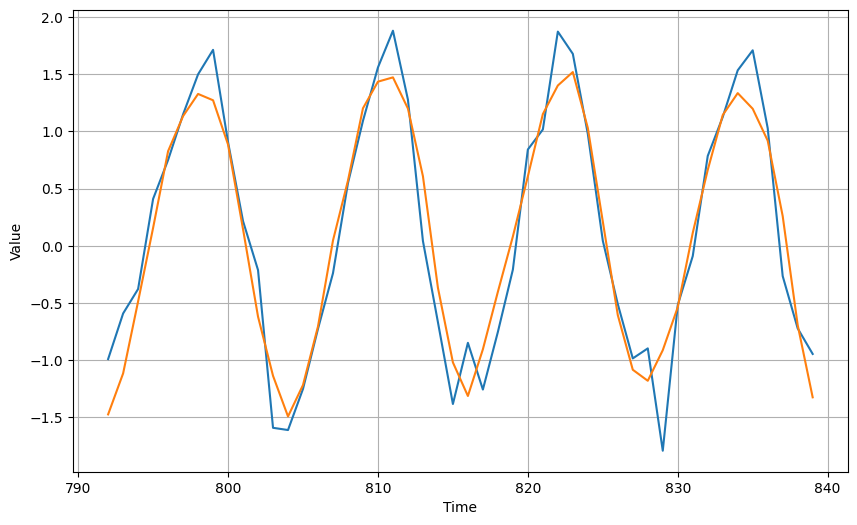

In [54]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

In [55]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

0.2417192